# Study model selection procedure for the adaboost algorithm

## Imports

In [2]:
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from optuna.study import MaxTrialsCallback
import timeout_decorator
from joblib import Parallel, delayed
import multiprocessing
from sklearn.metrics import log_loss
from sklearn.utils.class_weight import compute_class_weight
# add to path
import sys
sys.path.append("../")
from utils import load_lhco_rd, multi_roc_sigeffs, HGBPipeline
from matplotlib import pyplot as plt
import pandas as pd

## Load data and define necessary functions

In [3]:
datadict = load_lhco_rd("/home/lamprecht/code/treebased_ad_oldresults/treebased_ad/lhco_rd", shuffle=True)

x_full = np.concatenate((datadict["x_train"], datadict["x_val"]))
y_full = np.concatenate((datadict["y_train_databg"], datadict["y_val_databg"]))

In [4]:
def get_sample_weights(y):
    class_weights = compute_class_weight(
        class_weight='balanced', classes=np.unique(y), y=y,
        )

    sample_weights = ((np.ones(y.shape) - y)*class_weights[0]
                      + y*class_weights[1])
    
    return sample_weights

## Define the classifier based on the optimal hyperparameters that `optuna` found

In [5]:
clsf_hist_model = AdaBoostClassifier(
                estimator=DecisionTreeClassifier(
                    max_depth=None, min_samples_split=183, max_features="sqrt",
                    max_leaf_nodes=485, min_samples_leaf=16,
                    class_weight='balanced'
                    ),
                n_estimators=114, learning_rate=0.008445743523887637
                )

# note: here we dont use a standard scaler, but it has been shown to have
# almost no effect on tree-based classifiers
steps = [("adaboost", clsf_hist_model)]

model = HGBPipeline(steps=steps)

## Fit model

In [6]:
model.fit(datadict["x_train"], datadict["y_train_databg"])

HGBPipeline(steps=[('adaboost',
                    AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                        max_features='sqrt',
                                                                        max_leaf_nodes=485,
                                                                        min_samples_leaf=16,
                                                                        min_samples_split=183),
                                       learning_rate=0.008445743523887637,
                                       n_estimators=114))])

## Evaluate model on test set and plot SIC curve

In [7]:
test_preds = model.predict_proba(datadict["x_test"])[:,1]
tpr_vals, fpr_vals = multi_roc_sigeffs(test_preds.reshape((1, -1)),
                                       datadict["y_test"])

In [8]:
# Compute SIC
sic = tpr_vals/np.sqrt(fpr_vals)
na_mask = np.isfinite(sic)
tpr_forplot = tpr_vals[na_mask]
sic = sic[na_mask]

tmp_mask = (
    1/np.sqrt(fpr_vals[na_mask]
                * datadict["y_test"][datadict["y_test"] == 0].shape[0])
    ) < 0.2

sic = sic[tmp_mask]
tpr_forplot = tpr_forplot[tmp_mask]

/tmp/ipykernel_20579/3149546166.py:2: RuntimeWarning: divide by zero encountered in true_divide
  sic = tpr_vals/np.sqrt(fpr_vals)
/tmp/ipykernel_20579/3149546166.py:2: RuntimeWarning: invalid value encountered in true_divide
  sic = tpr_vals/np.sqrt(fpr_vals)


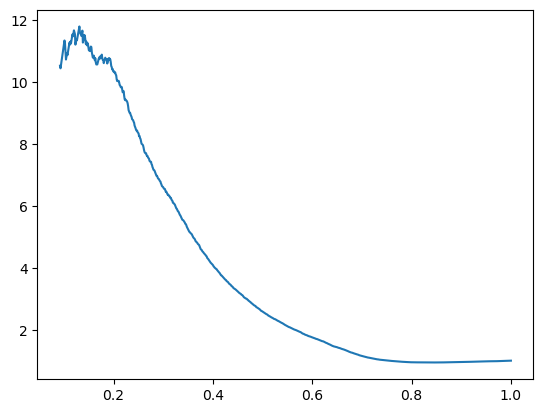

In [9]:
plt.plot(tpr_forplot, sic)

### Look at both total loss curves as well as separate loss curves based only on signal/background events

In [18]:
# get train losses
train_losses = []
train_weights = get_sample_weights(datadict["y_train_databg"])

for preds in model.staged_predict_proba(datadict["x_train"]):

    train_losses.append(log_loss(datadict["y_train_databg"], preds[:, 1],
                                 sample_weight=train_weights))

min_train_loss = np.min(train_losses)

# get val losses
val_losses = []
val_weights = get_sample_weights(datadict["y_val_databg"])

for preds in model.staged_predict_proba(datadict["x_val"]):

    val_losses.append(log_loss(datadict["y_val_databg"], preds[:, 1],
                                 sample_weight=val_weights))

min_val_loss = np.min(val_losses)

# get separate signal and background losses for training set

train_losses_sig = []
train_losses_bg = []

x_train_sig = datadict["x_train"][datadict["y_train_sigbg"] == 1]
x_train_bg = datadict["x_train"][datadict["y_train_sigbg"] == 0]
train_weights_sig = train_weights[datadict["y_train_sigbg"] == 1]
train_weights_bg = train_weights[datadict["y_train_sigbg"] == 0]

for preds in model.staged_predict_proba(x_train_sig):
    

    train_losses_sig.append(
        log_loss(datadict["y_train_databg"][datadict["y_train_sigbg"] == 1],
                 preds[:, 1], labels=[0, 1],
                 sample_weight=train_weights_sig))


for preds in model.staged_predict_proba(x_train_bg):

    train_losses_bg.append(
        log_loss(datadict["y_train_databg"][datadict["y_train_sigbg"] == 0],
                 preds[:, 1], labels=[0, 1],
                 sample_weight=train_weights_bg))

# get separate signal and background losses for validation set

val_losses_sig = []
val_losses_bg = []

x_val_sig = datadict["x_val"][datadict["y_val_sigbg"] == 1]
x_val_bg = datadict["x_val"][datadict["y_val_sigbg"] == 0]
val_weights_sig = val_weights[datadict["y_val_sigbg"] == 1]
val_weights_bg = val_weights[datadict["y_val_sigbg"] == 0]

for preds in model.staged_predict_proba(x_val_sig):
    

    val_losses_sig.append(
        log_loss(datadict["y_val_databg"][datadict["y_val_sigbg"] == 1],
                 preds[:, 1], labels=[0, 1],
                 sample_weight=val_weights_sig))


for preds in model.staged_predict_proba(x_val_bg):

    val_losses_bg.append(
        log_loss(datadict["y_val_databg"][datadict["y_val_sigbg"] == 0],
                 preds[:, 1], labels=[0, 1],
                 sample_weight=val_weights_bg))

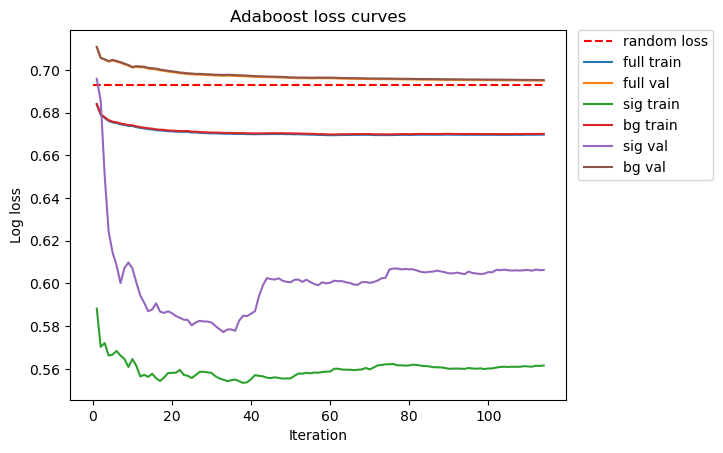

In [32]:
x_axis = np.arange(1, 115)
plt.hlines(-np.log(0.5), 0, 114, color="red", ls="dashed", label="random loss")
plt.plot(x_axis, train_losses, label="full train")
plt.plot(x_axis, val_losses, label="full val")
plt.plot(x_axis, train_losses_sig, label="sig train")
plt.plot(x_axis, train_losses_bg, label="bg train")
plt.plot(x_axis, val_losses_sig, label="sig val")
plt.plot(x_axis, val_losses_bg, label="bg val")
#plt.ylim(0.68, 0.71)
plt.xlabel("Iteration")
plt.ylabel("Log loss")
plt.title("Adaboost loss curves")
plt.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.savefig("adaboost_loss_breakdown.pdf", bbox_inches="tight")
plt.show()

We can see that the validation loss of the signal events first goes down and then increases again. The background validation loss is high in the beginning and then continuously decreases. Therefore, it makes sense to look at the prediction distributions at the best signal val loss iteration as well as the best background val loss iteration, which is the final one (and also the one with the lowest total validation loss).

In [33]:
best_sig_iter = np.argmin(val_losses_sig)
for idx, preds in enumerate(model.staged_predict_proba(datadict["x_test"])):
    if idx == best_sig_iter:
        test_preds_best_sig = preds[:, 1]

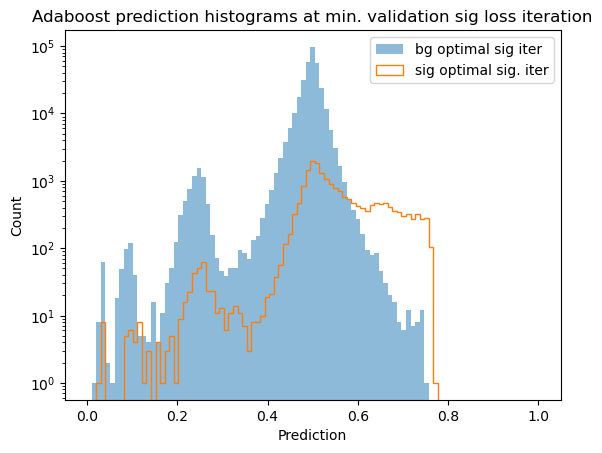

In [34]:
bg_preds_best_sig = test_preds_best_sig[datadict["y_test"] == 0]
sig_preds_best_sig = test_preds_best_sig[datadict["y_test"] == 1]

bins = np.linspace(0, 1, 100)

plt.hist(bg_preds_best_sig, bins=bins, alpha=0.5, label="bg optimal sig iter")
plt.hist(sig_preds_best_sig, bins=bins, label="sig optimal sig. iter", histtype="step")
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.yscale("log")
plt.legend(loc="upper right")
plt.title("Adaboost prediction histograms at min. validation sig loss iteration")
plt.savefig("adaboost_best_sig_iter_hist.pdf", bbox_inches="tight")
plt.show()

Repeat for final iteration

In [35]:
for idx, preds in enumerate(model.staged_predict_proba(datadict["x_test"])):
    if idx == 113:
        test_preds_final = preds[:, 1]

sig_preds_final = test_preds_final[datadict["y_test"] == 1]
bg_preds_final = test_preds_final[datadict["y_test"] == 0]

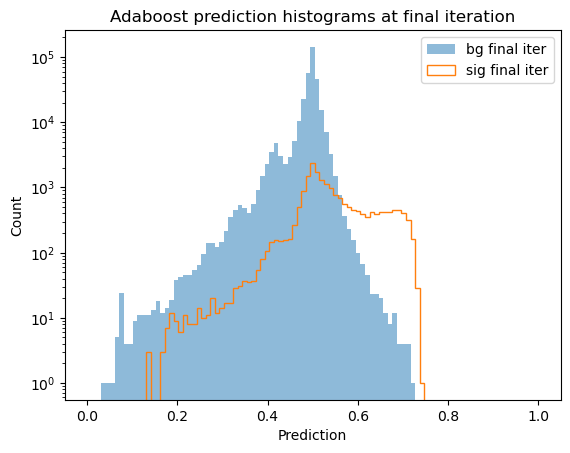

In [36]:
bins = np.linspace(0, 1, 100)

plt.hist(bg_preds_final, bins=bins, alpha=0.5, label="bg final iter")
plt.hist(sig_preds_final, bins=bins, label="sig final iter", histtype="step")
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.yscale("log")
plt.legend(loc="upper right")
plt.title("Adaboost prediction histograms at final iteration")
plt.savefig("adaboost_final_iter_hist.pdf", bbox_inches="tight")
plt.show()

It can be seen that the best signal iteration has fewer events in the lower tail and also has qute a large fraction of events in a higher region "shoulder". However, the background distribution looks more distorted and in general also broader, which is not the case for the final iteration.

Since it's difficult to see a clear difference by eye, let's compute the SIC curves for both iterations and compare them. 

In [37]:
# TPR, FPR for final iteration

tpr_vals_final, fpr_vals_final = multi_roc_sigeffs(test_preds_final.reshape((1, -1)),
                                       datadict["y_test"])

# Compute SIC
sic_final = tpr_vals_final/np.sqrt(fpr_vals_final)
na_mask = np.isfinite(sic_final)
tpr_forplot_final = tpr_vals_final[na_mask]
sic_final = sic_final[na_mask]

tmp_mask = (
    1/np.sqrt(fpr_vals_final[na_mask]
                * datadict["y_test"][datadict["y_test"] == 0].shape[0])
    ) < 0.2

sic_final = sic_final[tmp_mask]
tpr_forplot_final = tpr_forplot_final[tmp_mask]

# TPR, FPR for best sig iter

tpr_vals_best_sig, fpr_vals_best_sig = multi_roc_sigeffs(test_preds_best_sig.reshape((1, -1)),
                                       datadict["y_test"])

# Compute SIC
sic_best_sig = tpr_vals_best_sig/np.sqrt(fpr_vals_best_sig)
na_mask = np.isfinite(sic_best_sig)
tpr_forplot_best_sig = tpr_vals_best_sig[na_mask]
sic_best_sig = sic_best_sig[na_mask]

tmp_mask = (
    1/np.sqrt(fpr_vals_best_sig[na_mask]
                * datadict["y_test"][datadict["y_test"] == 0].shape[0])
    ) < 0.2

sic_best_sig = sic_best_sig[tmp_mask]
tpr_forplot_best_sig = tpr_forplot_best_sig[tmp_mask]

/tmp/ipykernel_20579/1040248469.py:7: RuntimeWarning: divide by zero encountered in true_divide
  sic_final = tpr_vals_final/np.sqrt(fpr_vals_final)
/tmp/ipykernel_20579/1040248469.py:7: RuntimeWarning: invalid value encountered in true_divide
  sic_final = tpr_vals_final/np.sqrt(fpr_vals_final)
/tmp/ipykernel_20579/1040248469.py:26: RuntimeWarning: divide by zero encountered in true_divide
  sic_best_sig = tpr_vals_best_sig/np.sqrt(fpr_vals_best_sig)
/tmp/ipykernel_20579/1040248469.py:26: RuntimeWarning: invalid value encountered in true_divide
  sic_best_sig = tpr_vals_best_sig/np.sqrt(fpr_vals_best_sig)


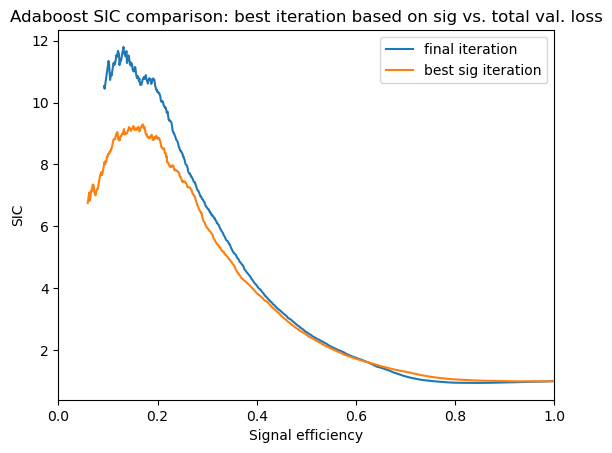

In [38]:
plt.plot(tpr_forplot_final, sic_final, label="final iteration")
plt.plot(tpr_forplot_best_sig, sic_best_sig, label="best sig iteration")
plt.xlabel("Signal efficiency")
plt.ylabel("SIC")
plt.legend(loc="upper right")
plt.xlim(0,1)
plt.title("Adaboost SIC comparison: best iteration based on sig vs. total val. loss")
plt.savefig("adaboost_sic_comparison.pdf", bbox_inches="tight")
plt.show()

We can clearly see that using the overall best validation iteration (which is also the best background validation iteration) leads to a better SIC curve than using the best signal validation iteration. This reflects the fact that in the weakly supervised case with only few signal events present, it is typically more important to have a good background rejection than to have a good signal efficiency.